# pvlib with PySAM financial model example
<img src="Tutorial_E_data/SAM-logo-horizontal.png"
     width= "500" />
<img src="Tutorial_E_data/pvlib_logo_horiz.png"
     width= "500" />
## Run pvlib modelchain, pass power and energy results to SAM financial models for technoeconomic analysis
## Steps:
### 1. Setup [pvlib](https://pvlib-python.readthedocs.io/en/stable/index.html)
### 2. Generate kW, kWh results from pvlib modelchain
### 3. Setup [PySAM](https://nrel-pysam.readthedocs.io/en/main/index.html), relevant financial parameters
### 4. Run financial model
### 5. Analyze project cashflows, project success metrics

In [11]:
import pvlib

import pandas as pd

import matplotlib.pyplot as plt

#Salt Lake City coordinates and weather data
coordinates = [
    (40.7608, -111.8910, 'Salt Lake City', 1319, 'Etc/GMT-7')
]



sandia_modules = pvlib.pvsystem.retrieve_sam('SandiaMod')

sapm_inverters = pvlib.pvsystem.retrieve_sam('cecinverter')

module = sandia_modules['Canadian_Solar_CS5P_220M___2009_']
modules_per_string = 21
strings_per_inverter = 250

inverter = sapm_inverters['Sungrow_Power_Supply_Co___Ltd___SC1000KU__540V_']


temperature_model_parameters = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']

In [12]:
tmys = []

for location in coordinates:
    latitude, longitude, name, altitude, timezone = location
    weather = pvlib.iotools.get_pvgis_tmy(latitude, longitude)[0]
    weather.index.name = "utc_time"
    tmys.append(weather)

## PVLib ModelChain
- Run models as different objects
- More information at https://pvlib-python.readthedocs.io/en/stable/user_guide/introtutorial.html

Salt Lake City    1.973942e+06
dtype: float64
utc_time
2012-01-01 00:00:00+00:00   -3.003918e+02
2012-01-01 01:00:00+00:00   -3.003918e+02
2012-01-01 02:00:00+00:00   -3.003918e+02
2012-01-01 03:00:00+00:00   -3.003918e+02
2012-01-01 04:00:00+00:00   -3.003918e+02
                                 ...     
2005-12-31 19:00:00+00:00    1.001306e+06
2005-12-31 20:00:00+00:00    1.001306e+06
2005-12-31 21:00:00+00:00    6.466355e+05
2005-12-31 22:00:00+00:00    5.047714e+05
2005-12-31 23:00:00+00:00    1.675182e+05
Length: 8760, dtype: float64


Text(0, 0.5, 'Power (W)')

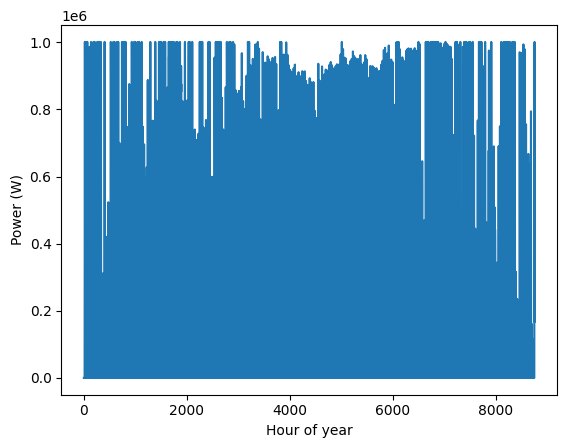

In [13]:
from pvlib.pvsystem import PVSystem, Array, FixedMount

from pvlib.location import Location

from pvlib.modelchain import ModelChain

energies = {}

for location, weather in zip(coordinates, tmys):
    latitude, longitude, name, altitude, timezone = location
    location = Location(
        latitude,
        longitude,
        name=name,
        altitude=altitude,
        tz=timezone,
    )
    mount = FixedMount(surface_tilt=latitude, surface_azimuth=180)
    array = Array(
        mount=mount,
        module_parameters=module,
        temperature_model_parameters=temperature_model_parameters,
        modules_per_string=modules_per_string,
        strings=strings_per_inverter
    )
    system = PVSystem(arrays=[array], inverter_parameters=inverter)
    mc = ModelChain(system, location)
    mc.run_model(weather)
    annual_energy = mc.results.ac.sum() #AC power series
    energies[name] = annual_energy


energies = pd.Series(energies)/1000


print(energies)
print(mc.results.ac)






plt.plot(range(0,8760,1), mc.results.ac)
plt.xlabel('Hour of year')
plt.ylabel('Power (W)')

## SAM PPA Financial Models
- Front of meter, single entity selling generated power at agreed upon Power Purchase Agreement (PPA) price
- Includes project Capex, Opex, Revenue (PPA), Debt, Incentives (Investment Tax Credit), and Depreciation
- Setup inputs in desktop tool, export [PySAM JSON's](https://nrel-pysam.readthedocs.io/en/main/getting-started.html#example-1-build-a-model-from-sam), iterate in PySAM
  
  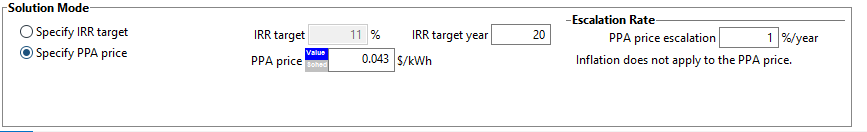
  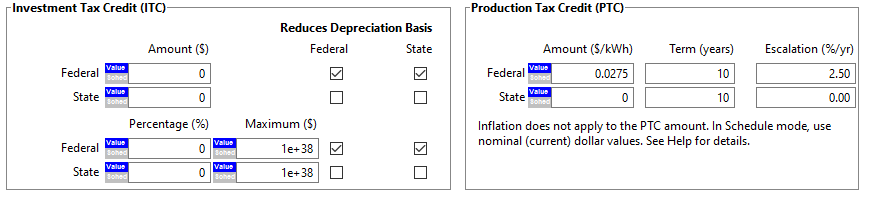

In [14]:
import json
import PySAM.Singleowner as so # import the Single Owner module from PySAM
import PySAM.Cashloan as co #Residential/Commercial BTM financial, covered in next section

# create a new instance of the Singleowner module
so_model = so.new()

#Setup model in SAM, export JSON files with inputs
#For more information on PySAM input json's, see https://nrel-pysam.readthedocs.io/en/main/getting-started.html

#Alternatively, start with default inputs to financial model (may not be accurate for your case)

so_model = so.default("FlatPlatePVSingleOwner")


# get the inputs from the JSON file
with open( 'Tutorial_E_data/SO_example_singleowner.json', 'r') as f:
        so_inputs = json.load( f )

# iterate through the input key-value pairs and set the module inputs
for k, v in so_inputs.items():
    if k != 'number_inputs':
        so_model.value(k, v)

In [15]:
so_model.export() #View inputs

{'Revenue': {'dispatch_factors_ts': (0.7,
   0.7,
   0.7,
   0.7,
   0.7,
   0.7,
   0.8,
   0.8,
   1.1,
   1.1,
   1.1,
   1.1,
   1.1,
   1.1,
   1.1,
   1.1,
   1.1,
   1.1,
   1.1,
   1.1,
   1.1,
   0.8,
   0.8,
   0.8,
   0.7,
   0.7,
   0.7,
   0.7,
   0.7,
   0.7,
   0.8,
   0.8,
   1.1,
   1.1,
   1.1,
   1.1,
   1.1,
   1.1,
   1.1,
   1.1,
   1.1,
   1.1,
   1.1,
   1.1,
   1.1,
   0.8,
   0.8,
   0.8,
   0.7,
   0.7,
   0.7,
   0.7,
   0.7,
   0.7,
   0.8,
   0.8,
   1.1,
   1.1,
   1.1,
   1.1,
   1.1,
   1.1,
   1.1,
   1.1,
   1.1,
   1.1,
   1.1,
   1.1,
   1.1,
   0.8,
   0.8,
   0.8,
   0.7,
   0.7,
   0.7,
   0.7,
   0.7,
   0.7,
   0.8,
   0.8,
   1.1,
   1.1,
   1.1,
   1.1,
   1.1,
   1.1,
   1.1,
   1.1,
   1.1,
   1.1,
   1.1,
   1.1,
   1.1,
   0.8,
   0.8,
   0.8,
   0.7,
   0.7,
   0.7,
   0.7,
   0.7,
   0.7,
   0.8,
   0.8,
   1.1,
   1.1,
   1.1,
   1.1,
   1.1,
   1.1,
   1.1,
   1.1,
   1.1,
   1.1,
   1.1,
   1.1,
   1.1,
   0.8,
   0.8,
   0.8,
   0.7

## Energy input to Financial Model
- Financial model needs timeseries power production (kWAC)
- SAM calculates for annual degradation, set system_use_lifetime_output to 0 for single year of results
- system_use_lifetime_output = 0 for AC degradation, = 1 for DC degradation (multi-year time series)
- Set annual degradation as a flat %/yr or annual schedule

In [16]:
so_model.SystemOutput.gen = mc.results.ac / 1000 #kWAC
so_model.Lifetime.system_use_lifetime_output = 0 
so_model.SystemOutput.degradation = [0.5] #%/yr
so_model.FinancialParameters.system_capacity = 1153.53 #DC capacity, needed for O&M scaling

## Costs
- SAM has various cost categories used to calculate total capex, opex
- Only total capex is passed to financial model
- opex categories ( / kW/yr, $/yr, $/kWh/yr) are passed to financial model

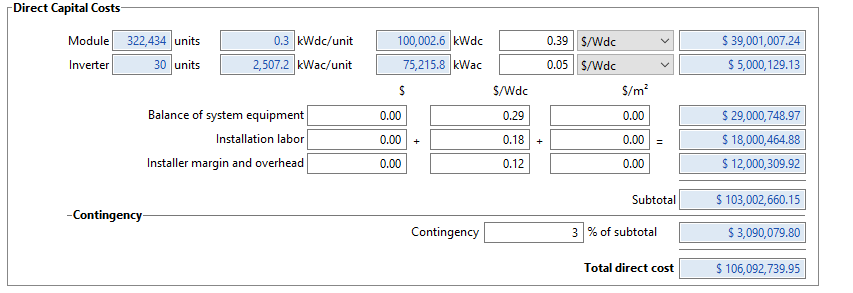

In [17]:
#Modify cost values
so_model.SystemCosts.total_installed_cost = 1350000 #$ (Capex)
#Capacity based OM - can be single value or annual schedule, enter as an array of size 1 for fixed input
so_model.SystemCosts.om_capacity = [15] #$/kW/yr (Opex)
print(so_model.SystemCosts.om_fixed) #Show that fixed O&M costs are $0, only capacity based OM in this example

(0.0,)


## Revenue
- ppa_soln_mode: 2 different solution modes
  1. Specify IRR target: PPA price is unknown, iteratively solve for PPA price that gives desired IRR target in target year
  2. Specify PPA price: PPA price is known, is used to calculate IRR of project

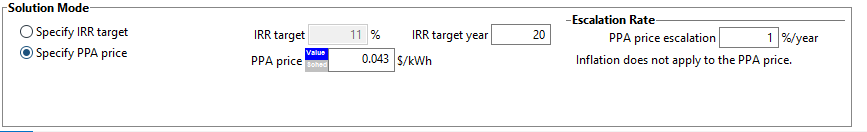

In [18]:
#Modify revenue, PPA
so_model.Revenue.ppa_soln_mode = 1 #Specify PPA Price
#PPA price can be single value, annual schedule
#Can also add an escalation rate, inflation does not apply
so_model.Revenue.ppa_price_input = [0.055] #5.5 cents/kWh

#Alternate - Specify IRR target
#so_model.Revenue.ppa_soln_mode = 0 #Specify IRR target
# so_model.Revenue.flip_target_percent = 11 #%
# so_model.Revenue.flip_target_year = 20
# so_model.Revenue.ppa_escalation = 1 #%/yr


## Financing
- Project term debt
- Inflation rate
- Analysis period (period of performance)
- Construction financing

In [19]:
so_model.FinancialParameters.inflation_rate = 2.5 #%/yr
so_model.FinancialParameters.term_int_rate = 7 #%, annual interest rate
so_model.FinancialParameters.analysis_period = 25 #yrs, analysis period
so_model.FinancialParameters.construction_financing_cost = 35244.49 #$, total construction financing cost
so_model.FinancialParameters.real_discount_rate = 6.4 #%/yr
#Construction financing cost linked to total installed cost, any changes to total installed cost should include updates to any construction financing costs

## Incentives
- Investment Tax Credit
- Production Tax Credit
- Other investment based incentives (IBI), capacity based incentives (CBI), production based incentives (PBI)

In [20]:
#Set investment tax credit
so_model.TaxCreditIncentives.itc_fed_percent = [0] #%
so_model.TaxCreditIncentives.ptc_fed_amount = [0.0275] #$/kWh
so_model.TaxCreditIncentives.ptc_fed_term = 10 #years
so_model.TaxCreditIncentives.ptc_fed_escal = 2.5 #%/yr
so_model.PaymentIncentives.ibi_fed_amount = 0 #$ Federal investment based incentives

## Results
- Annual cashflows
- Net Present Value
- Internal Rate of Return
- Levelized Cost of Energy
- Other metrics and annual cashflow information

Net Present Value:  -20558.617404061835
Internal Rate of Return:  7.176400789734087
Levelized cost of energy (nominal):  4.83350644904887  cents/kWh


Text(0.5, 1.0, 'Project After-tax Cash Flow')

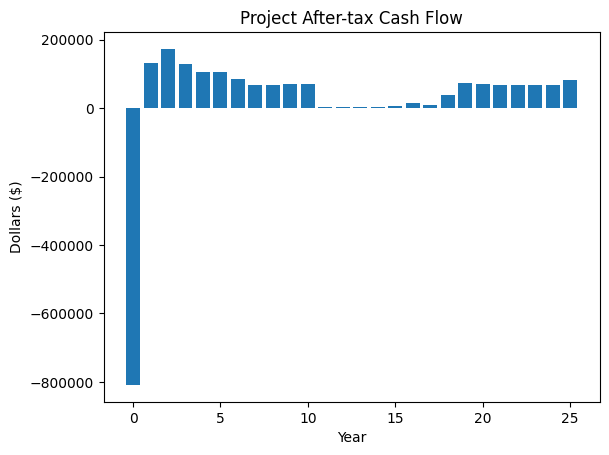

In [21]:
so_model.execute() #Run model
print("Net Present Value: ", so_model.Outputs.project_return_aftertax_npv)
print("Internal Rate of Return: ", so_model.Outputs.flip_actual_irr)
print("Levelized cost of energy (nominal): ", so_model.Outputs.lcoe_real, " cents/kWh")
plt.bar(range(0,int(so_model.FinancialParameters.analysis_period+1),1),so_model.Outputs.cf_project_return_aftertax)
plt.xlabel('Year')
plt.ylabel('Dollars ($)')
plt.title('Project After-tax Cash Flow')